# Pipeline for the anomaly detection on the SKAB using Convolutional Autoencoder

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

In [2]:
# libraries importing
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

sys.path.append("..")
from core.Conv_AE import Conv_AE
from core.metrics import chp_score
from core.utils import create_sequences, load_preprocess_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [3]:
Xy_traintest_list = load_preprocess_skab()

## Method

### Method initialization

In [4]:
# hyperparameters selection
N_STEPS = 60
Q = 0.999  # quantile for upper control limit (UCL) selection

In [5]:
# model defining
model = Conv_AE()

### Method fitting and applying

In [6]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)

    # model fitting
    model.fit(X)

    # results predicting
    residuals = pd.Series(
        np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1)
    )
    UCL = residuals.quantile(Q) * 4 / 3

    # results predicting
    X = create_sequences(StSc.transform(X_test), N_STEPS)
    cnn_residuals = pd.Series(
        np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1)
    )

    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    prediction = pd.Series(data=0, index=X_test.index)
    prediction.iloc[anomalous_data_indices] = 1

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["changepoint"])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22

### Results visualization

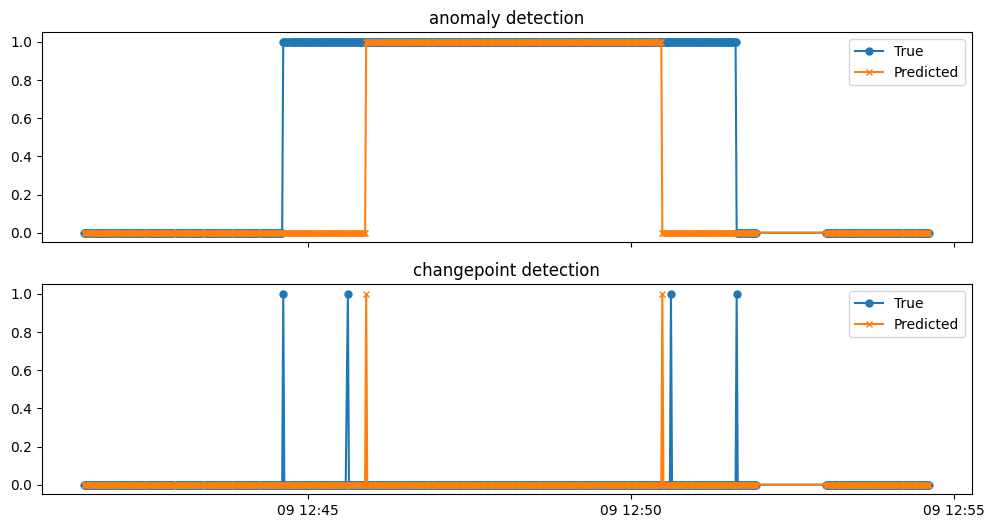

In [7]:
# [donotremove]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

In [8]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 13.55 %
Missing Alarm Rate 28.02 %
F1 metric 0.78


### Changepoint detection metrics

In [9]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 127
A number of missed CPs = 82
A number of FPs = 18
Average time 0 days 00:01:12.244444444


In [10]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="righter",
)

Standard  -  10.69
LowFP  -  8.35
LowFN  -  12.38
